In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [7]:
df = df['Resistance']
df

0      0.296
1      0.297
2      0.298
3      0.298
4      0.296
       ...  
250    0.619
251    0.620
252    0.623
253    0.639
254    0.634
Name: Resistance, Length: 255, dtype: float64

<AxesSubplot:>

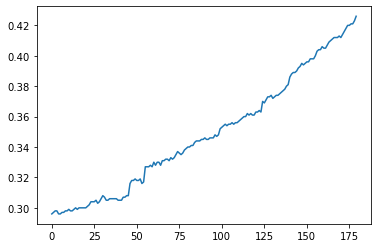

In [8]:
df = df[:180]
df.plot()

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [10]:
train = df_scaled

In [11]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [12]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [13]:
x_train.shape

(128, 20, 1)

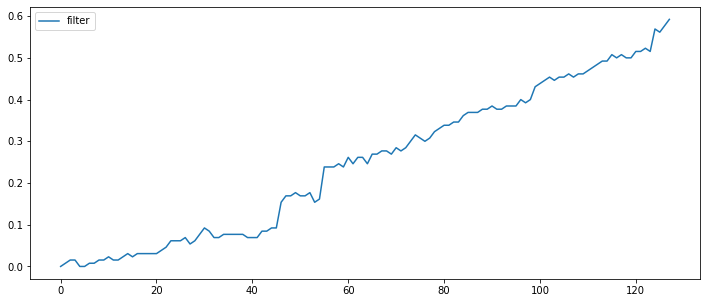

In [14]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

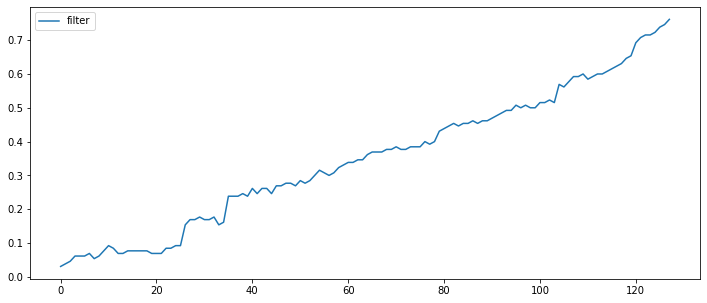

In [15]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [16]:
OUT_STEPS = 20

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(32, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [18]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
8/8 [==============================] - 1s 4ms/step - loss: 0.1289 - mean_absolute_error: 0.2993
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.1182 - mean_absolute_error: 0.2885
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0890 - mean_absolute_error: 0.2384
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0859 - mean_absolute_error: 0.2328
Epoch 5/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0757 - mean_absolute_error: 0.2233
Epoch 6/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0654 - mean_absolute_error: 0.2035
Epoch 7/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0429 - mean_absolute_error: 0.1640
Epoch 8/1000
8/8 [==============================] - 0s 3ms/step - loss: 0.0300 - mean_absolute_error: 0.1426
Epoch 9/1000
8/8 [==============================] - 0s 4ms/step - loss: 0.0214 - mean_absolute_error: 0.1211
Epoch 10/1000
8/8 [

8/8 [==============================] - 0s 4ms/step - loss: 3.1173e-04 - mean_absolute_error: 0.0135
Epoch 72/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.9263e-04 - mean_absolute_error: 0.0130
Epoch 73/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.8421e-04 - mean_absolute_error: 0.0129
Epoch 74/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.3338e-04 - mean_absolute_error: 0.0140
Epoch 75/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.3331e-04 - mean_absolute_error: 0.0139
Epoch 76/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.2407e-04 - mean_absolute_error: 0.0136
Epoch 77/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.5282e-04 - mean_absolute_error: 0.0142
Epoch 78/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.5457e-04 - mean_absolute_error: 0.0144
Epoch 79/1000
8/8 [==============================] - 0s 3ms/step - loss: 3.1605e-04 - mean_absolute_er

8/8 [==============================] - 0s 5ms/step - loss: 3.0720e-04 - mean_absolute_error: 0.0133
Epoch 142/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.1162e-04 - mean_absolute_error: 0.0133
Epoch 143/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.7330e-04 - mean_absolute_error: 0.0124
Epoch 144/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.2897e-04 - mean_absolute_error: 0.0137
Epoch 145/1000
8/8 [==============================] - 0s 5ms/step - loss: 3.1301e-04 - mean_absolute_error: 0.0133
Epoch 146/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.9221e-04 - mean_absolute_error: 0.0131
Epoch 147/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.8194e-04 - mean_absolute_error: 0.0127
Epoch 148/1000
8/8 [==============================] - 0s 4ms/step - loss: 3.0299e-04 - mean_absolute_error: 0.0132
Epoch 149/1000
8/8 [==============================] - 0s 3ms/step - loss: 2.6424e-04 - mean_abs

8/8 [==============================] - 0s 3ms/step - loss: 2.8027e-04 - mean_absolute_error: 0.0127
Epoch 212/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.7139e-04 - mean_absolute_error: 0.0125
Epoch 213/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5153e-04 - mean_absolute_error: 0.0120
Epoch 214/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.7039e-04 - mean_absolute_error: 0.0124
Epoch 215/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.6374e-04 - mean_absolute_error: 0.0125
Epoch 216/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.8802e-04 - mean_absolute_error: 0.0130
Epoch 217/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.6201e-04 - mean_absolute_error: 0.0123
Epoch 218/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.3743e-04 - mean_absolute_error: 0.0117
Epoch 219/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.3683e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 2.3351e-04 - mean_absolute_error: 0.0117
Epoch 282/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.3085e-04 - mean_absolute_error: 0.0115
Epoch 283/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.4307e-04 - mean_absolute_error: 0.0118
Epoch 284/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.5841e-04 - mean_absolute_error: 0.0122
Epoch 285/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.5463e-04 - mean_absolute_error: 0.0122
Epoch 286/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.4320e-04 - mean_absolute_error: 0.0119
Epoch 287/1000
8/8 [==============================] - 0s 6ms/step - loss: 2.2266e-04 - mean_absolute_error: 0.0114
Epoch 288/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2993e-04 - mean_absolute_error: 0.0116
Epoch 289/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.2987e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 2.1916e-04 - mean_absolute_error: 0.0115
Epoch 353/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.3368e-04 - mean_absolute_error: 0.0118
Epoch 354/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1056e-04 - mean_absolute_error: 0.0112
Epoch 355/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.3464e-04 - mean_absolute_error: 0.0118
Epoch 356/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.1186e-04 - mean_absolute_error: 0.0113
Epoch 357/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0612e-04 - mean_absolute_error: 0.0110
Epoch 358/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2822e-04 - mean_absolute_error: 0.0117
Epoch 359/1000
8/8 [==============================] - 0s 4ms/step - loss: 2.2758e-04 - mean_absolute_error: 0.0117
Epoch 360/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.2704e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 2.0646e-04 - mean_absolute_error: 0.0112
Epoch 424/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9970e-04 - mean_absolute_error: 0.0111
Epoch 425/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9237e-04 - mean_absolute_error: 0.0107
Epoch 426/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0823e-04 - mean_absolute_error: 0.0112
Epoch 427/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.0201e-04 - mean_absolute_error: 0.0110
Epoch 428/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9267e-04 - mean_absolute_error: 0.0107
Epoch 429/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.9851e-04 - mean_absolute_error: 0.0110
Epoch 430/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9547e-04 - mean_absolute_error: 0.0108
Epoch 431/1000
8/8 [==============================] - 0s 5ms/step - loss: 2.1409e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.9306e-04 - mean_absolute_error: 0.0107
Epoch 494/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8462e-04 - mean_absolute_error: 0.0105
Epoch 495/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8563e-04 - mean_absolute_error: 0.0105
Epoch 496/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7266e-04 - mean_absolute_error: 0.0101
Epoch 497/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7672e-04 - mean_absolute_error: 0.0102
Epoch 498/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7715e-04 - mean_absolute_error: 0.0102
Epoch 499/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8548e-04 - mean_absolute_error: 0.0106
Epoch 500/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7944e-04 - mean_absolute_error: 0.0103
Epoch 501/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.9887e-04 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.7510e-04 - mean_absolute_error: 0.0102
Epoch 564/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7324e-04 - mean_absolute_error: 0.0101
Epoch 565/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6665e-04 - mean_absolute_error: 0.0098
Epoch 566/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.8477e-04 - mean_absolute_error: 0.0105
Epoch 567/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6887e-04 - mean_absolute_error: 0.0100
Epoch 568/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8756e-04 - mean_absolute_error: 0.0105
Epoch 569/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.8038e-04 - mean_absolute_error: 0.0105
Epoch 570/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7707e-04 - mean_absolute_error: 0.0103
Epoch 571/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7173e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.8000e-04 - mean_absolute_error: 0.0102
Epoch 634/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8777e-04 - mean_absolute_error: 0.0105
Epoch 635/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7452e-04 - mean_absolute_error: 0.0102
Epoch 636/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8206e-04 - mean_absolute_error: 0.0104
Epoch 637/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7294e-04 - mean_absolute_error: 0.0102
Epoch 638/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7288e-04 - mean_absolute_error: 0.0101
Epoch 639/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8242e-04 - mean_absolute_error: 0.0105
Epoch 640/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7834e-04 - mean_absolute_error: 0.0103
Epoch 641/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8387e-04 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.7904e-04 - mean_absolute_error: 0.0103
Epoch 705/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6808e-04 - mean_absolute_error: 0.0100
Epoch 706/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7258e-04 - mean_absolute_error: 0.0101
Epoch 707/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7750e-04 - mean_absolute_error: 0.0102
Epoch 708/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6128e-04 - mean_absolute_error: 0.0097
Epoch 709/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6391e-04 - mean_absolute_error: 0.0098
Epoch 710/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6228e-04 - mean_absolute_error: 0.0098
Epoch 711/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7278e-04 - mean_absolute_error: 0.0101
Epoch 712/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.8366e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.8205e-04 - mean_absolute_error: 0.0105
Epoch 776/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6286e-04 - mean_absolute_error: 0.0098
Epoch 777/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6734e-04 - mean_absolute_error: 0.0099
Epoch 778/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7217e-04 - mean_absolute_error: 0.0100
Epoch 779/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7332e-04 - mean_absolute_error: 0.0101
Epoch 780/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6553e-04 - mean_absolute_error: 0.0098
Epoch 781/1000
8/8 [==============================] - 0s 6ms/step - loss: 1.6096e-04 - mean_absolute_error: 0.0098
Epoch 782/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6915e-04 - mean_absolute_error: 0.0100
Epoch 783/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7524e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.4757e-04 - mean_absolute_error: 0.0094
Epoch 846/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.5959e-04 - mean_absolute_error: 0.0097
Epoch 847/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6834e-04 - mean_absolute_error: 0.0099
Epoch 848/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7356e-04 - mean_absolute_error: 0.0099
Epoch 849/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.5978e-04 - mean_absolute_error: 0.0097
Epoch 850/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.6847e-04 - mean_absolute_error: 0.0100
Epoch 851/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7777e-04 - mean_absolute_error: 0.0101
Epoch 852/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4583e-04 - mean_absolute_error: 0.0093
Epoch 853/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5413e-04 - mean_abs

8/8 [==============================] - 0s 5ms/step - loss: 1.5725e-04 - mean_absolute_error: 0.0096
Epoch 916/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5593e-04 - mean_absolute_error: 0.0096
Epoch 917/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6222e-04 - mean_absolute_error: 0.0098
Epoch 918/1000
8/8 [==============================] - 0s 3ms/step - loss: 1.5911e-04 - mean_absolute_error: 0.0096
Epoch 919/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5596e-04 - mean_absolute_error: 0.0095
Epoch 920/1000
8/8 [==============================] - 0s 5ms/step - loss: 1.7060e-04 - mean_absolute_error: 0.0099
Epoch 921/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4590e-04 - mean_absolute_error: 0.0092
Epoch 922/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.7631e-04 - mean_absolute_error: 0.0101
Epoch 923/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6343e-04 - mean_abs

8/8 [==============================] - 0s 4ms/step - loss: 1.5826e-04 - mean_absolute_error: 0.0095
Epoch 986/1000
8/8 [==============================] - ETA: 0s - loss: 1.0595e-04 - mean_absolute_error: 0.007 - 0s 4ms/step - loss: 1.4159e-04 - mean_absolute_error: 0.0090
Epoch 987/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6206e-04 - mean_absolute_error: 0.0097
Epoch 988/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5177e-04 - mean_absolute_error: 0.0092
Epoch 989/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.5263e-04 - mean_absolute_error: 0.0094
Epoch 990/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.4549e-04 - mean_absolute_error: 0.0092
Epoch 991/1000
8/8 [==============================] - 0s 7ms/step - loss: 1.6336e-04 - mean_absolute_error: 0.0096
Epoch 992/1000
8/8 [==============================] - 0s 4ms/step - loss: 1.6296e-04 - mean_absolute_error: 0.0097
Epoch 993/1000
8/8 [=================

num 0 15.640908021193365 actual 0.6190476190476186 prediction 0.7158723
num 1 7.250353693962193 actual 0.6666666666666661 prediction 0.71500236
num 2 1.8816208839417587 actual 0.7142857142857135 prediction 0.72772586
num 3 3.8094379007817385 actual 0.7619047619047628 prediction 0.7328805
num 4 2.502129077911486 actual 0.7142857142857135 prediction 0.73215806
num 5 11.347311735153296 actual 0.6666666666666661 prediction 0.7423154
num 6 13.91381025314341 actual 0.6666666666666661 prediction 0.7594254
num 7 15.750077366829021 actual 0.6666666666666661 prediction 0.7716672
num 8 9.575997591018794 actual 0.7142857142857135 prediction 0.7826857
num 9 10.175276994705317 actual 0.7142857142857135 prediction 0.78696626
num 10 13.712908029556395 actual 0.7142857142857135 prediction 0.81223506
num 11 20.33395469188701 actual 0.6666666666666661 prediction 0.80222636
num 12 15.759817361831788 actual 0.7142857142857135 prediction 0.82685584
num 13 10.702805966138715 actual 0.7619047619047628 predict

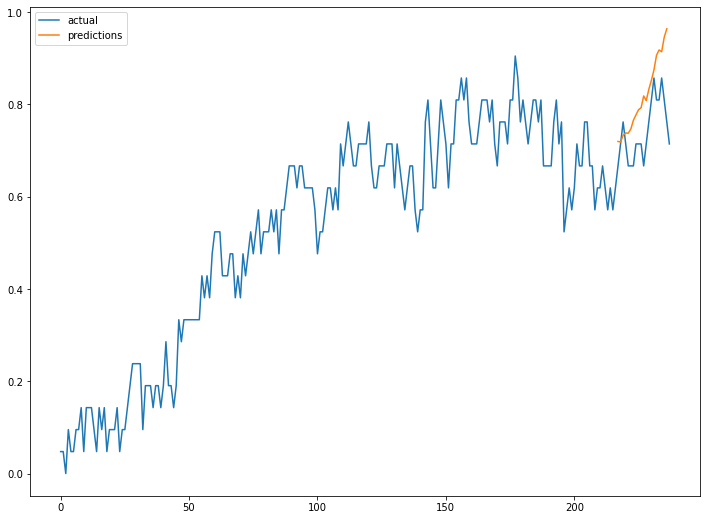

In [19]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 9.214728024541095 actual 0.8006535947712417 prediction 0.72687554
num 1 10.911434263952318 actual 0.8104575163398693 prediction 0.722025
num 2 10.557802613959256 actual 0.8137254901960784 prediction 0.72781396
num 3 9.23513741493225 actual 0.8169934640522876 prediction 0.741543
num 4 9.433205890655517 actual 0.8169934640522876 prediction 0.7399248
num 5 8.001242975789708 actual 0.8202614379084967 prediction 0.7546303
num 6 7.383403288045885 actual 0.826797385620915 prediction 0.7657516
num 7 5.539923440664997 actual 0.8366013071895424 prediction 0.79025424
num 8 6.023492039860892 actual 0.8464052287581698 prediction 0.7954221
num 9 6.117985166352355 actual 0.8529411764705881 prediction 0.80075836
num 10 3.6336247005389932 actual 0.8594771241830064 prediction 0.82824695
num 11 5.41859120130537 actual 0.8627450980392155 prediction 0.81599647
num 12 3.10722971862215 actual 0.8660130718954246 prediction 0.83910406
num 13 0.783158563218005 actual 0.8660130718954246 prediction 0.859230

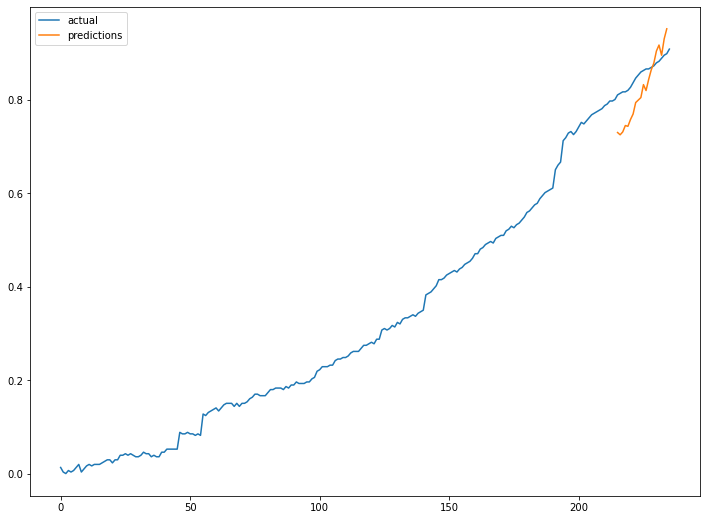

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 2.462622396734221 actual 0.6762402088772845 prediction 0.65958697
num 1 4.504223551714044 actual 0.6892950391644908 prediction 0.65824765
num 2 4.5427331763706595 actual 0.6971279373368144 prediction 0.6654593
num 3 4.019420829404221 actual 0.702349869451697 prediction 0.6741195
num 4 4.776016284618853 actual 0.7075718015665795 prediction 0.67377806
num 5 4.271795127513638 actual 0.7154046997389034 prediction 0.6848441
num 6 4.799196369759068 actual 0.7284595300261096 prediction 0.6934993
num 7 4.176249331383321 actual 0.7389033942558747 prediction 0.70804495
num 8 4.604586533137712 actual 0.7493472584856395 prediction 0.7148429
num 9 4.5193895542910205 actual 0.7545691906005221 prediction 0.72046727
num 10 3.1172873623948782 actual 0.7650130548302871 prediction 0.7411654
num 11 3.971815595821466 actual 0.7676240208877285 prediction 0.7371354
num 12 1.7404773000146332 actual 0.7676240208877285 prediction 0.7542637
num 13 1.5165451789062157 actual 0.7780678851174934 prediction 0.7

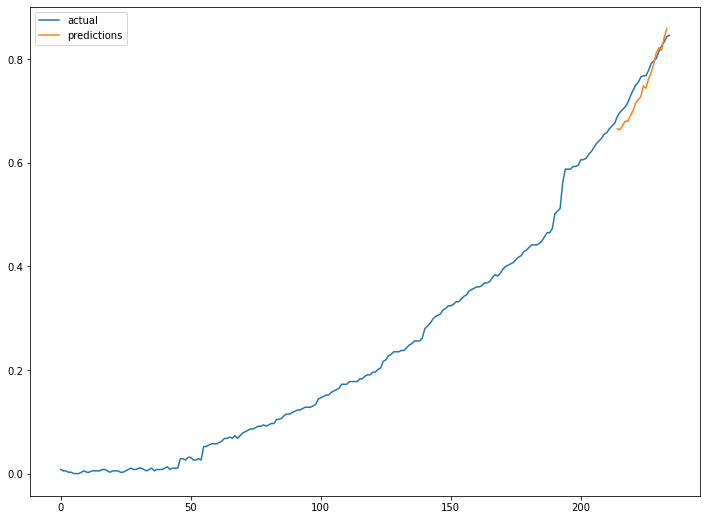

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.681672849153148 actual 0.7916666666666661 prediction 0.74668676
num 1 6.234407424926688 actual 0.7916666666666661 prediction 0.74231094
num 2 3.913462789435064 actual 0.7916666666666661 prediction 0.7606851
num 3 2.4132728576660156 actual 0.75 prediction 0.76809955
num 4 3.034827583714463 actual 0.7916666666666661 prediction 0.76764095
num 5 3.4235080083211265 actual 0.75 prediction 0.7756763
num 6 4.14891481399543 actual 0.8333333333333339 prediction 0.79875904
num 7 2.266676425933907 actual 0.8333333333333339 prediction 0.81444436
num 8 10.018038749694766 actual 0.9166666666666661 prediction 0.82483464
num 9 13.405505470607645 actual 0.9583333333333339 prediction 0.8298639
num 10 10.524274991906262 actual 0.9583333333333339 prediction 0.8574757
num 11 11.960570708565145 actual 0.9583333333333339 prediction 0.8437112
num 12 9.16677557903793 actual 0.9583333333333339 prediction 0.87048507
num 13 6.187604821246661 actual 0.9583333333333339 prediction 0.89903545
num 14 0.14555670

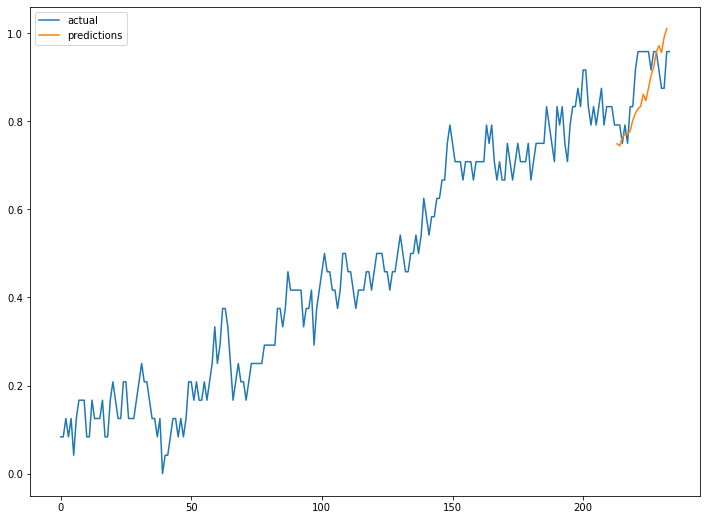

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 10.701040970651714 actual 0.8482142857142856 prediction 0.7574465
num 1 12.346514066060346 actual 0.8571428571428568 prediction 0.7513156
num 2 10.740083393297684 actual 0.8482142857142856 prediction 0.75711536
num 3 9.338728420397347 actual 0.8526785714285712 prediction 0.77304924
num 4 10.926931912137041 actual 0.8660714285714284 prediction 0.7714364
num 5 10.049745014735631 actual 0.875 prediction 0.78706473
num 6 8.94182757072641 actual 0.8794642857142856 prediction 0.8008241
num 7 6.533737757697137 actual 0.8883928571428568 prediction 0.8303476
num 8 5.567385933615918 actual 0.8839285714285712 prediction 0.83471686
num 9 5.430660535342689 actual 0.8883928571428568 prediction 0.84014726
num 10 1.4704896946145747 actual 0.8839285714285712 prediction 0.8709305
num 11 4.382411003112787 actual 0.8928571428571428 prediction 0.8537285
num 12 2.24961667957869 actual 0.901785714285714 prediction 0.881499
num 13 0.02645295241783405 actual 0.90625 prediction 0.90648973
num 14 1.4013553

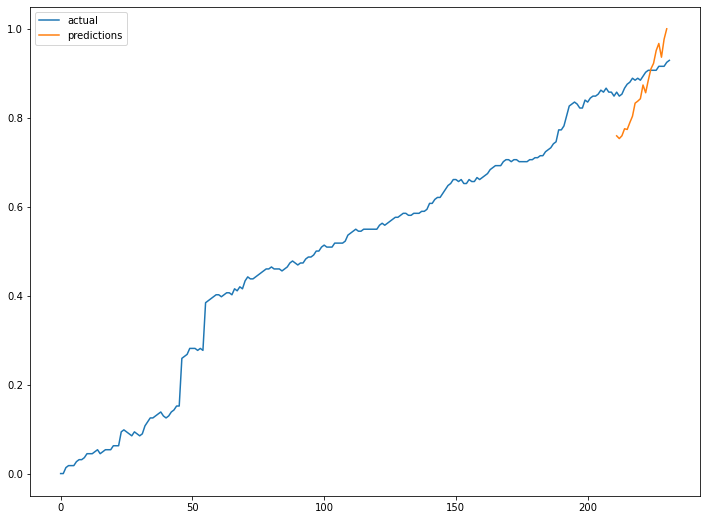

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.570976762210769 actual 0.8500000000000014 prediction 0.7516467
num 1 6.974278390407646 actual 0.8000000000000007 prediction 0.7442058
num 2 1.146205266316732 actual 0.75 prediction 0.74140346
num 3 1.68303648630778 actual 0.75 prediction 0.7626228
num 4 1.410079002380371 actual 0.75 prediction 0.7605756
num 5 4.083776473999023 actual 0.75 prediction 0.7806283
num 6 12.37577029636911 actual 0.7000000000000011 prediction 0.7866304
num 7 17.71977799279331 actual 0.7000000000000011 prediction 0.82403845
num 8 26.805956547076814 actual 0.6500000000000004 prediction 0.8242387
num 9 18.472422872270677 actual 0.7000000000000011 prediction 0.82930696
num 10 14.84528382619222 actual 0.75 prediction 0.8613396
num 11 12.583676973978678 actual 0.75 prediction 0.8443776
num 12 24.11656549998673 actual 0.7000000000000011 prediction 0.86881596
num 13 27.26002080099904 actual 0.7000000000000011 prediction 0.89082015
num 14 12.42816597223272 actual 0.8000000000000007 prediction 0.8994253
num 15

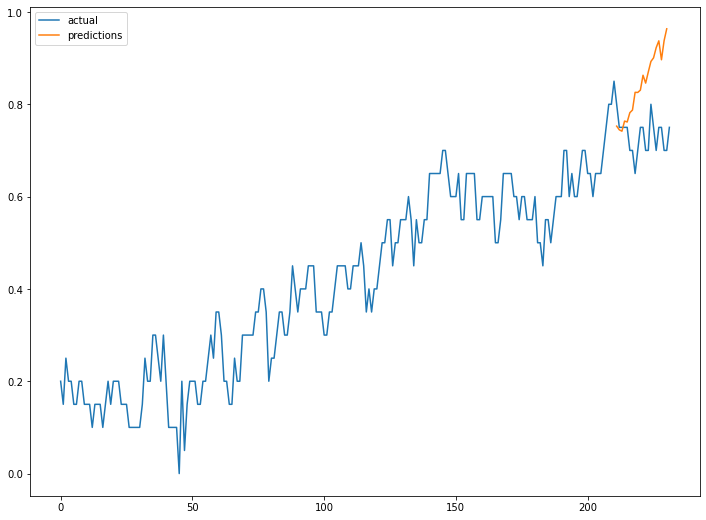

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 11.339476704597375 actual 0.8421052631578938 prediction 0.74661493
num 1 14.630722638332463 actual 0.8684210526315788 prediction 0.7413648
num 2 11.606021970510385 actual 0.8421052631578938 prediction 0.74437034
num 3 12.498885573762818 actual 0.8684210526315788 prediction 0.7598781
num 4 12.718080390583367 actual 0.8684210526315788 prediction 0.75797457
num 5 7.977741956710712 actual 0.8421052631578938 prediction 0.7749243
num 6 3.719925880432035 actual 0.8157894736842097 prediction 0.7854427
num 7 0.18130194756282803 actual 0.8157894736842097 prediction 0.81431043
num 8 2.7680695056914204 actual 0.8421052631578938 prediction 0.8187952
num 9 2.1942589432000026 actual 0.8421052631578938 prediction 0.8236273
num 10 1.688241958618143 actual 0.8684210526315788 prediction 0.85376
num 11 0.47906301915634547 actual 0.8421052631578938 prediction 0.83807105
num 12 3.406253281761583 actual 0.8947368421052628 prediction 0.86425984
num 13 1.8250729098464722 actual 0.8684210526315788 predict

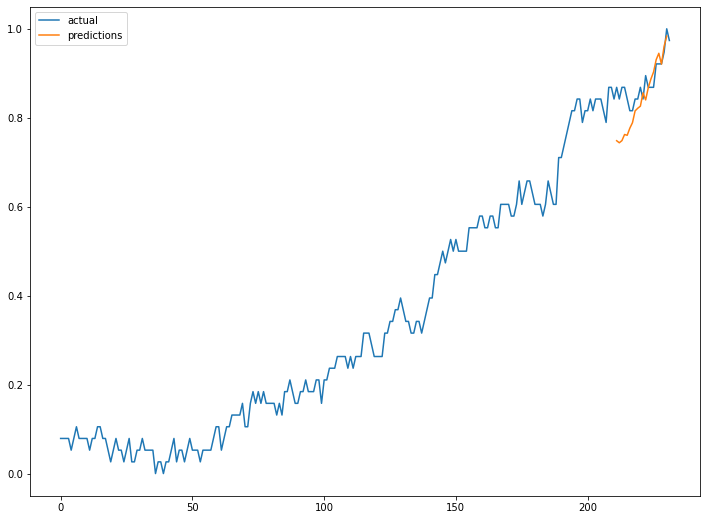

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.701994299888711 actual 0.76923076923077 prediction 0.7253693
num 1 1.3088960396617375 actual 0.7307692307692317 prediction 0.7212042
num 2 0.6454442676746264 actual 0.7307692307692317 prediction 0.7260525
num 3 1.1224282415288305 actual 0.7307692307692317 prediction 0.7389716
num 4 6.473194890552201 actual 0.6923076923076916 prediction 0.7371221
num 5 2.1733576059342474 actual 0.76923076923077 prediction 0.75251263
num 6 5.581941491081681 actual 0.8076923076923084 prediction 0.7626074
num 7 2.6387118157887146 actual 0.8076923076923084 prediction 0.78637964
num 8 6.369851394133194 actual 0.8461538461538467 prediction 0.7922551
num 9 1.3021366936820729 actual 0.8076923076923084 prediction 0.79717505
num 10 7.196548581123238 actual 0.76923076923077 prediction 0.82458884
num 11 5.615430474281199 actual 0.76923076923077 prediction 0.8124264
num 12 8.66747379302967 actual 0.76923076923077 prediction 0.83590364
num 13 5.6228864760625035 actual 0.8076923076923084 prediction 0.8531079
n

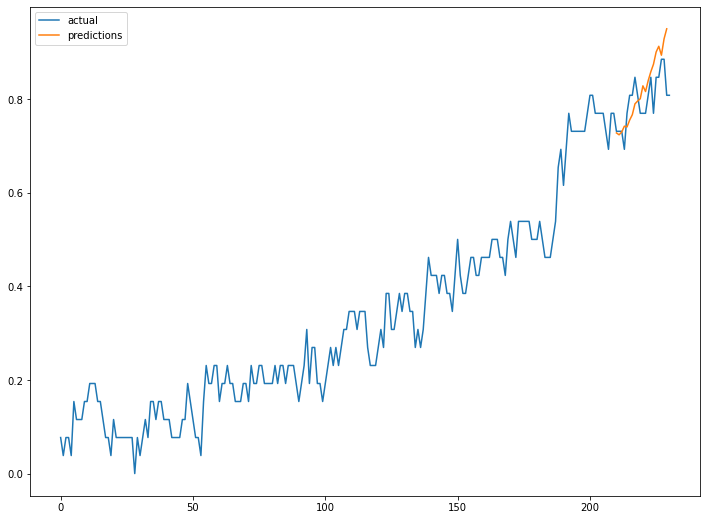

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 5.031158884366323 actual 0.7389162561576352 prediction 0.7017402
num 1 6.793555107555887 actual 0.7487684729064039 prediction 0.6979005
num 2 6.833529784009302 actual 0.7536945812807878 prediction 0.70219064
num 3 5.735232342373209 actual 0.7586206896551722 prediction 0.71511203
num 4 7.120853356825993 actual 0.7684729064039408 prediction 0.7137511
num 5 5.836409823909693 actual 0.7733990147783252 prediction 0.7282603
num 6 5.377046933656972 actual 0.7783251231527091 prediction 0.7364742
num 7 3.106187349595342 actual 0.7832512315270934 prediction 0.758922
num 8 3.0806964635848906 actual 0.7881773399014778 prediction 0.763896
num 9 3.0163521352021627 actual 0.7931034482758621 prediction 0.76918066
num 10 0.4476773886032662 actual 0.798029556650246 prediction 0.79445696
num 11 1.58125897984442 actual 0.798029556650246 prediction 0.78541064
num 12 0.3086911105527989 actual 0.8078817733990147 prediction 0.8053879
num 13 0.14462574513369786 actual 0.8226600985221673 prediction 0.8214

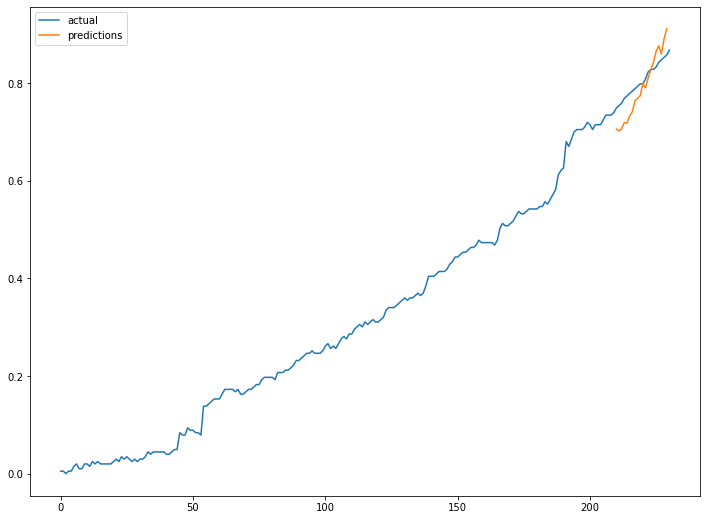

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()